# Keras
* Tensorflow es una herramienta potente y flexible, pero programar grandes redes con Tensorflow puede ser tedioso.
* Hay muchos paquetes de aprendizaje profundo que funcionan sobre Tensorflow, como Slim, TFLearn, Sonnet, Keras.
* La elección depende del gusto del desarrollador y de la tarea.
* Nosotros usaremos Keras.

In [2]:
#import sys
#sys.path.append("..")

In [6]:
# se usan datasets y modelos precargardos en keras
import download_utils
download_utils.download_all_keras_resources("readonly/keras/models", "readonly/keras/datasets")
! mkdir -p ~/.keras/datasets
! mkdir -p ~/.keras/models
! ln -s $(realpath ../readonly/keras/datasets/*) ~/.keras/datasets/
! ln -s $(realpath ../readonly/keras/models/*) ~/.keras/models/


realpath: '../readonly/keras/datasets/*': No existe el archivo o el directorio
ln: fallo al crear el enlace simbólico './datasets': El archivo ya existe
realpath: '../readonly/keras/models/*': No existe el archivo o el directorio
ln: fallo al crear el enlace simbólico './models': El archivo ya existe


In [9]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
from preprocessed_mnist import load_dataset
import keras
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
y_train,y_val,y_test = map(keras.utils.np_utils.to_categorical,[y_train,y_val,y_test])

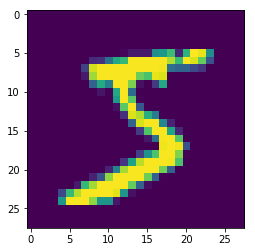

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0]);

## Red con keras

In [12]:
import tensorflow as tf
from keras_utils import reset_tf_session
s = reset_tf_session()

In [19]:
import keras
from keras.models import Sequential
from keras.utils.multi_gpu_utils import multi_gpu_model
import keras.layers as ll

modelo = Sequential(name="mlp")   # perceptron multicapa

modelo.add(ll.InputLayer([28, 28]))

modelo.add(ll.Flatten())

# cuerpo de la red
modelo.add(ll.Dense(25))
modelo.add(ll.Activation('linear'))

modelo.add(ll.Dense(25))
modelo.add(ll.Activation('linear'))

# capa de salida: 10 neuronas para cada clase con sigmoide (softmax)
modelo.add(ll.Dense(10, activation='softmax'))

# categorical_crossentropy es la entropia cruzada de toda la vida
# pero aplicada a vectores con one hot encoding
modelo.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

#modelo_multi = keras.utils.multi_gpu_model(model, gpus=1, cpu_merge=True, cpu_relocation=False)
#modelo_multi.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

In [20]:
modelo.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 25)                19625     
_________________________________________________________________
activation_7 (Activation)    (None, 25)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 25)                650       
_________________________________________________________________
activation_8 (Activation)    (None, 25)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                260       
Total params: 20,535
Trainable params: 20,535
Non-trainable params: 0
_________________________________________________________________


### Interfaz del modelo

Los modelos de Keras funcionan con la interfaz de __Scikit-learn__ usando fit/predict con algunas extensiones. Veamoslo.

In [ ]:
# Entrena
modelo.fit(X_train, y_train,
                validation_data=(X_val, y_val), epochs=1000);

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
50000/50000 [==============================] - 9s 175us/step - loss: 0.4056 - acc: 0.8836 - val_loss: 0.2695 - val_acc: 0.9238
Epoch 2/1000
50000/50000 [==============================] - 7s 144us/step - loss: 0.3000 - acc: 0.9149 - val_loss: 0.2692 - val_acc: 0.9273
Epoch 3/1000
50000/50000 [==============================] - 7s 143us/step - loss: 0.2891 - acc: 0.9192 - val_loss: 0.2809 - val_acc: 0.9206
Epoch 4/1000
50000/50000 [==============================] - 7s 145us/step - loss: 0.2806 - acc: 0.9210 - val_loss: 0.2649 - val_acc: 0.9272
Epoch 5/1000
50000/50000 [==============================] - 8s 151us/step - loss: 0.2763 - acc: 0.9213 - val_loss: 0.2675 - val_acc: 0.9264
Epoch 6/1000
50000/50000 [==============================] - 8s 153us/step - loss: 0.2711 - acc: 0.9242 - val_loss: 0.2755 - val_acc: 0.9248
Epoch 7/1000
50000/50000 [==============================] - 8s

In [ ]:
# Estima la probabilidades P(y|x)
modelo.predict_proba(X_val[:2])

In [ ]:
# Guarda los pesos de entrenamiento
model.save("weights.h5")

In [ ]:
print("\nPerdida, Acierto = ", model.evaluate(X_test, y_test))

### Whoops!
So far, our model is staggeringly inefficient. There is something wrong with it. Guess, what?

In [ ]:
# Test score...
test_predictions = model.predict_proba(X_test).argmax(axis=-1)
test_answers = y_test.argmax(axis=-1)

test_accuracy = np.mean(test_predictions==test_answers)

print("\nTest accuracy: {} %".format(test_accuracy*100))

assert test_accuracy>=0.92,"Logistic regression can do better!"
assert test_accuracy>=0.975,"Your network can do better!"
print("Great job!")

## Keras + tensorboard

Remember the interactive graphs from Tensorboard one notebook ago? 

Thing is, Keras can use tensorboard to show you a lot of useful information about the learning progress. Just take a look!

In [ ]:
! rm -r /tmp/tboard/**

In [ ]:
from keras.callbacks import TensorBoard
model.fit(X_train, y_train, validation_data=(X_val, y_val), 
          epochs=10,
          callbacks=[TensorBoard("/tmp/tboard")])

# Tips & tricks

Here are some tips on what you could do. Don't worry, to reach the passing threshold you don't need to try all the ideas listed here, feel free to stop once you reach the 0.975 accuracy mark.

 * __Network size__
   * More neurons, 
   * More layers, ([docs](https://keras.io/))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
     

 * __Faster optimization__
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - https://keras.io/regularizers/
   
   
 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * https://keras.io/preprocessing/image/
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.